In [1]:
# import libraries
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction
from matipo.util.etl import deinterlace
from pathlib import Path
import ipyvolume as ipv
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    if (p*4)%l==0: # only print 4 times per run
        print(p, '/', l)

### 3D Flow Velocity Vector Experiment

This experiment measures a 3D map of the flow velocity vector `(vx, vy, vz)`.
The velocities are time-averaged, so a sample with laminar flow is recommended.

Flow speed can be controlled with the Stepper Control dashboard app.
The final image may be incorrect due to phase wrapping if the flow speed is too fast.
Recommended speed: 400 steps/s

First we set a directory and experiment name for saving the data:

In [2]:
# set save directory and base file name
SAVE_DIR = '/home/data/flow-3D-RARE'
SAVE_NAME = 'test'

# make the save directory if it doesn't exist
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

#### Now we run the experiment:
1. load the pulse sequence
2. load global variables (pulse calibration, frequency, shims)
3. set up 3D image parameters
4. run 4 times with flow encode gradient directions, storing kspace data in a 4D array `data`:
    1. +x, +y, +z
    2. -x, -y, +z
    3. -x, +y, -z
    4. +x, -y, -z

In [14]:
# load pulse sequence
seq = Sequence('flow-RARE.py')

# load relevant global variables
seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'shims.yaml')


G_CAL = 8.0e6 # Hz/m at max grad
DECIMATION = 4
G_FLOW_MAG = 0.5
G_FLOW_DIR = np.array([
    (1, 1, 1),
    (-1, -1, 1),
    (-1, 1, -1),
    (1, -1, -1)
])
# multiply magnitude by normalised directions
G_FLOW = G_FLOW_MAG * (G_FLOW_DIR/np.linalg.norm(G_FLOW_DIR, axis=1)[:,np.newaxis])

# set parameters for a 16x16x20 X/Y/Z 3D SE image
seq.setpar(
    n_ETL=8,
    
    # phase encode X axis
    n_phase_1=16,
    g_phase_1=(-1.0, 0, 0),

    # phase encode Y axis
    n_phase_2=16,
    g_phase_2=(0, -1.0, 0),
    
    # frequency encode Z axis
    t_dw=5e-6,
    n_samples=DECIMATION*20,
    g_read=(0, 0, 0.5), # read gradient (0.5)
    
    t_qfilter=400e-6,
    g_qfilter=(0.5, -0.5, 0.5),
    
    g_spoil=(0, 0, 0.5), # same direction as read gradient
    t_spoil=4000e-6,
    
    t_flow=1000e-6,
    t_flow_spacing=1200e-6,
    g_flow=(0,0,0),
    g_flow_tweak=(0.998,0.998,0.998),

    t_end=200e-3,
    n_scans=4
)

# seq.setpar(t_phase=200e-6)
seq.setpar(t_phase=np.abs(np.linalg.norm(seq.par.g_read)/np.linalg.norm(seq.par.g_phase_2))*(seq.par.t_dw*DECIMATION*seq.par.n_phase_2)/2)

# calculate VENC, the velocity that produces a pi phase shift
g_flow_x = np.diagonal(np.dot(G_FLOW.T, G_FLOW_DIR))[0]
VENC = np.pi/(2*np.pi*G_CAL*g_flow_x*seq.par.t_flow*seq.par.t_flow_spacing) # assume VENC same for all dimensions for now

# print out the parameter set for reference
print(seq.par)
print('Venc:', VENC)

# # not perfectly accurate, but close enough
# t_echo = 2*seq.par.t_phase + 4*seq.par.t_grad_ramp + seq.par.t_dw*seq.par.n_samples
# time_est_s = 4*(seq.par.n_scans*seq.par.n_phase_1*(2*seq.par.n_phase_2*t_echo+seq.par.t_spoil+seq.par.t_end))
# print('total time (mins):', time_est_s/60)
# print('t_end acc. (mins):', 4*seq.par.n_scans*seq.par.n_phase_1*seq.par.t_end/60)

data = []

for i in range(len(G_FLOW)):
    print(f'Acquiring image {i+1}/{len(G_FLOW)} with g_flow={G_FLOW[i]}')
    seq.setpar(g_flow=G_FLOW[i])
    await seq.run(progress_handler=print_progress)
    data.append(
        decimate(deinterlace(seq.data, seq.par.n_ETL, seq.par.n_phase_1, seq.par.n_phase_2, seq.par.n_samples), DECIMATION, axis=2))
    seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}.yaml')
data = np.array(data)
np.save(f'{SAVE_DIR}/{SAVE_NAME}', data)

ParameterSet(n_scans=4, f=15090930.400958482, a_90=0.34987021061682183, t_90=3.2e-05, a_180=0.7263180024450473, t_180=3.2e-05, t_dw=5e-06, n_samples=80, g_read=array([0. , 0. , 0.5]), t_phase=8e-05, n_phase_1=16, g_phase_1=array([-1.,  0.,  0.]), n_phase_2=16, g_phase_2=array([ 0., -1.,  0.]), n_ETL=8, t_flow=0.001, t_flow_spacing=0.0012, g_flow=array([0., 0., 0.]), g_flow_tweak=array([0.998, 0.998, 0.998]), t_qfilter=0.0004, g_qfilter=array([ 0.5, -0.5,  0.5]), t_spoil=0.004, g_spoil=array([0. , 0. , 0.5]), t_end=0.2, t_grad_ramp=0.0001, n_grad_ramp=10, shim_x=0.2516507394086332, shim_y=0.2052708730092634, shim_z=-0.5324265450827718, shim_z2=-0.18237496664422603, shim_zx=-0.6074221755538733, shim_zy=0.06831180888614677, shim_xy=0.026255879788701985, shim_x2y2=0.3359226462136782)
Venc: 0.04510548978043951
Acquiring image 1/4 with g_flow=[0.28867513 0.28867513 0.28867513]
1 / 4
2 / 4
3 / 4
4 / 4
Acquiring image 2/4 with g_flow=[-0.28867513 -0.28867513  0.28867513]
1 / 4
2 / 4
3 / 4
4 / 

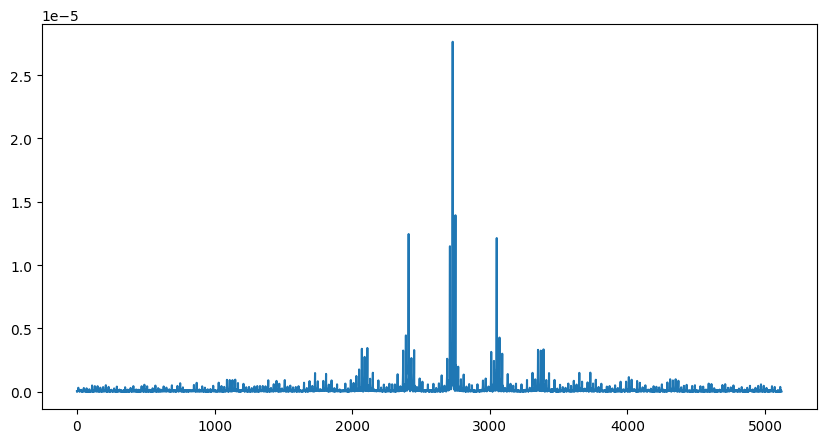

In [15]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(np.abs(data[0].flatten()))
plt.show()

#### Reconstruct the images from k-space data using fourier method:

In [16]:
im = []
for i in range(len(G_FLOW)):
    # run IFT with some upscaling and windowing to get the images
    im.append(fft_reconstruction(data[i], upscale_factor=2, gaussian_blur=1))
im = np.array(im)

#### Plot a slice in the XY plane of the images and a mask of regions with significant signal:

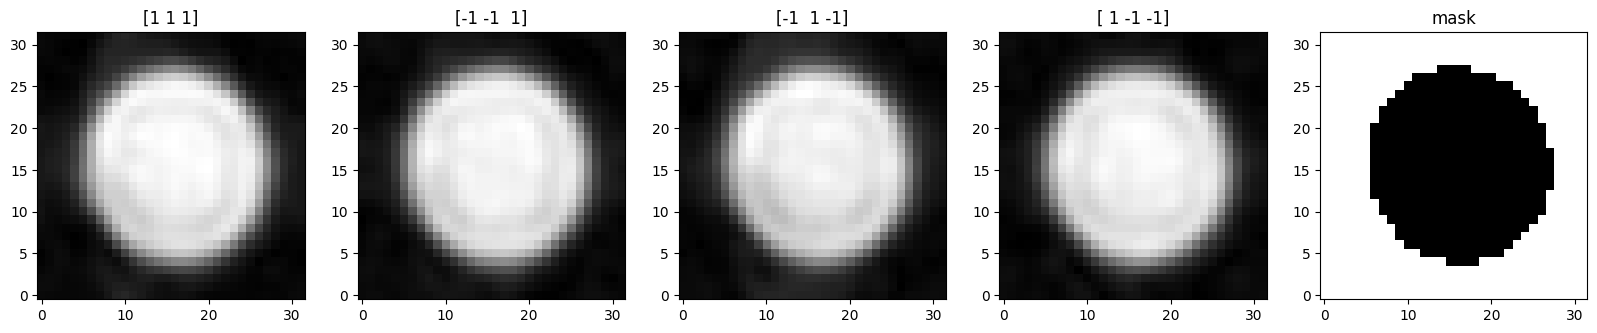

In [17]:
# make a filter array by thresholding the magnitude of the base signal
# this can be used to exclude areas with no signal when plotting phase difference
filt = np.mean(np.abs(im)**2, axis=0)
thresh = 1*np.mean(filt) # adjust to alter the threshold, half max is a good starting point
filt[filt > thresh] = 1
filt[filt <= thresh] = np.nan

# plot X/Y slice of signal magnitude at the centre of the Z axis
# to check we have signal in all images
cmap='gray'
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i in range(4):
    axes.flatten()[i].imshow(np.abs(im[i][:,:,im[i].shape[2]//2]), origin='lower', cmap=cmap)
    axes.flatten()[i].set_title(str(G_FLOW_DIR[i]))
axes.flatten()[4].imshow(np.abs(filt[:,:,filt.shape[2]//2]), origin='lower', cmap=cmap)
axes.flatten()[4].set_title('mask')
plt.show()

#### XZ Plane

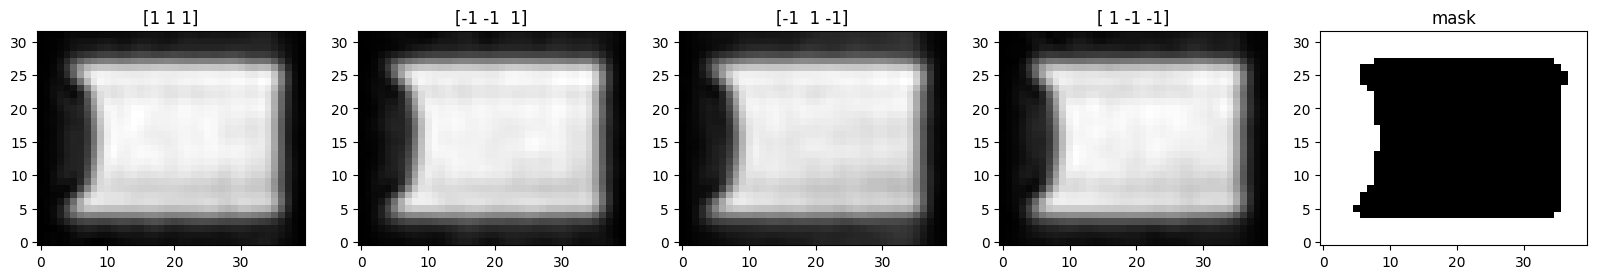

In [18]:
# plot X/Z slice of signal magnitude at the centre of the Y axis
# to check we have signal in all images
cmap='gray'
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i in range(4):
    axes.flatten()[i].imshow(np.abs(im[i][:,im[i].shape[1]//2,:]), origin='lower', cmap=cmap)
    axes.flatten()[i].set_title(str(G_FLOW_DIR[i]))
axes.flatten()[4].imshow(np.abs(filt[:,filt.shape[1]//2,:]), origin='lower', cmap=cmap)
axes.flatten()[4].set_title('mask')
plt.show()

#### Plot a slice in the XY plane of the phase of the images
The flow encode gradients will introduce a phase shift proportional to the flow velocity in the direction of the gradient.
We can plot maps of the phase to see this phase shift directly.

Note: the phase may also vary across the image, but we are interested in the differences between the encoded images and the base image.

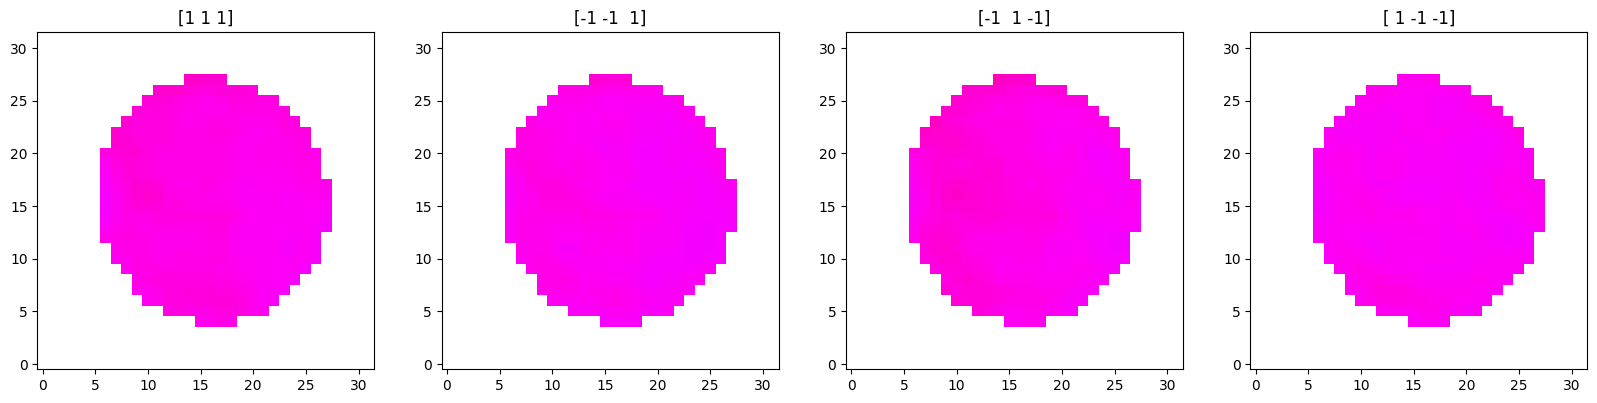

In [19]:
# plot X/Y slice of signal phase at the centre of the Z axis
cmap='hsv' # cyclical colormap for phase plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for i in range(4):
    axes.flatten()[i].imshow(filt[:,:,im[i].shape[2]//2]*np.angle(im[i][:,:,im[i].shape[2]//2]), origin='lower', cmap=cmap, vmin=-np.pi, vmax=np.pi)
    axes.flatten()[i].set_title(str(G_FLOW_DIR[i]))
plt.show()

#### XZ Plane

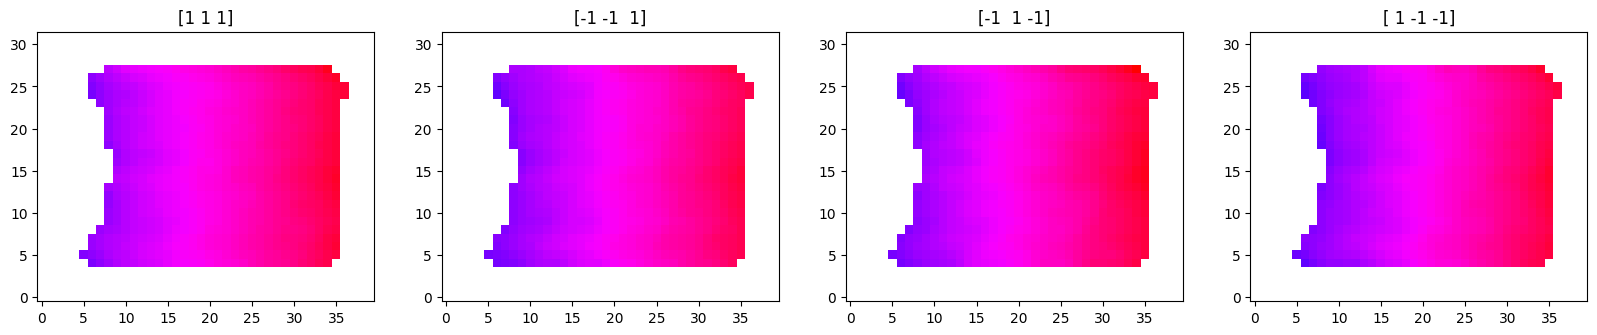

In [20]:
# plot X/Z slice of signal phase at the centre of the Y axis
cmap='hsv' # cyclical colormap for phase plots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for i in range(4):
    axes.flatten()[i].imshow(filt[:,im[i].shape[1]//2,:]*np.angle(im[i][:,im[i].shape[1]//2,:]), origin='lower', cmap=cmap, vmin=-np.pi, vmax=np.pi)
    axes.flatten()[i].set_title(str(G_FLOW_DIR[i]))
plt.show()

#### Calculate the flow velocity vector field

In [21]:
# calculate velocity from phase difference (uncalibrated, arbitrary units)
v = np.zeros((3, im.shape[1],im.shape[2],im.shape[3]))

# calculate phase and matrix multiply to get Vx, Vy, Vz
im_phase = np.angle(im)
phi = np.dot((filt[np.newaxis]*im_phase).T, G_FLOW_DIR).T
phi = ( phi + np.pi) % (2 * np.pi ) - np.pi # wrap phase

v = (phi/np.pi)*VENC

# maximum velocity magnitude, used for plots
v_mag_max = np.nanmax(np.linalg.norm(v, axis=0))
print('maximum speed:', v_mag_max, 'm/s')

maximum speed: 0.007254805572971929 m/s


#### Plot flow velocity vector in YZ, XZ, and XY planes
Flow in the plane is represented by arrows, and flow through the plane (perpendicular) is represented by colour.

Note: discontinuities in the flow velocity indicate that the flow speed is too fast, or flow encode gradient too strong, causing phase wrapping.

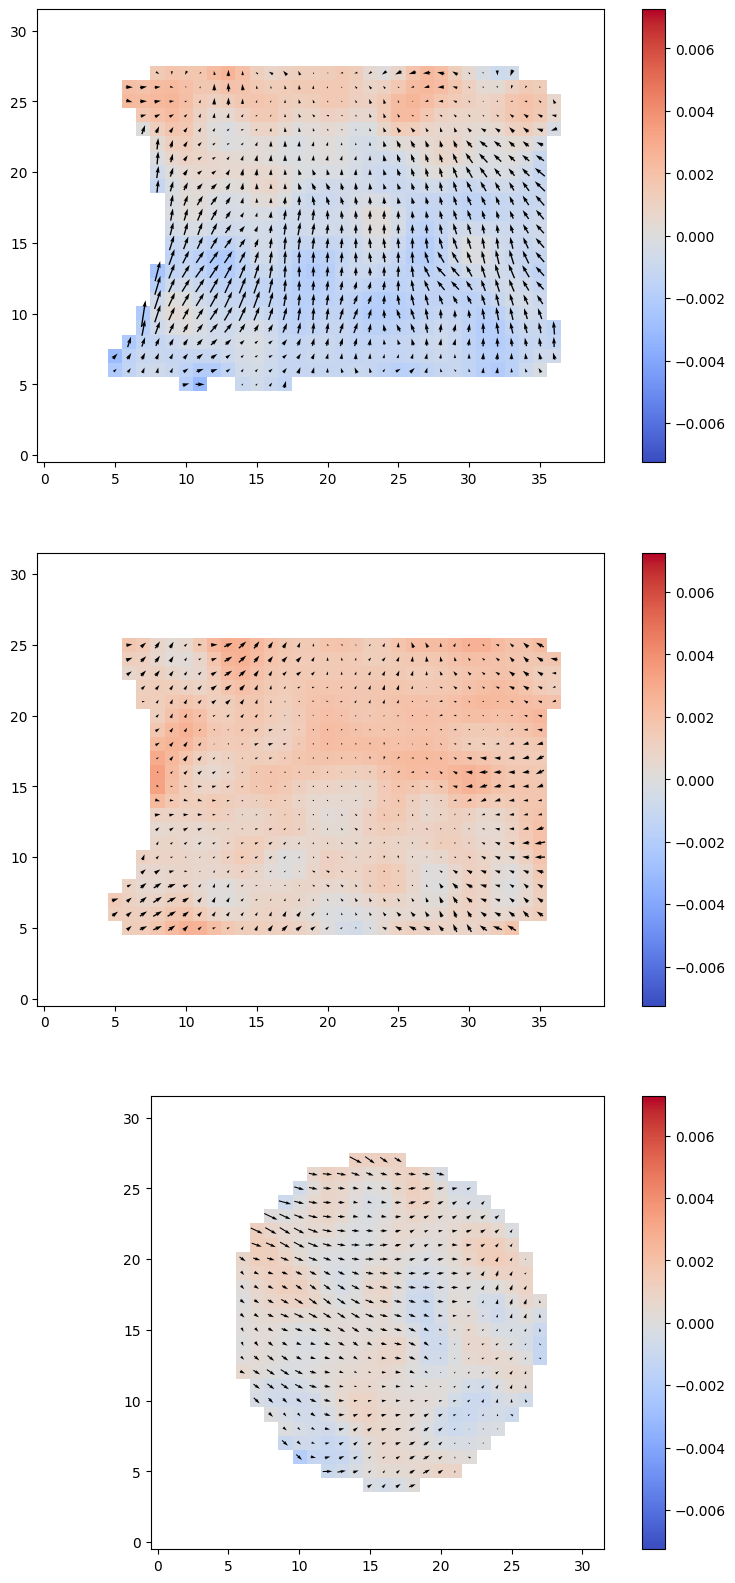

In [22]:
# For each plane through the centre (Y/Z, X/Z, X/Y) plot a map of the flow.
# The component orthogonal to the plane is represented by the backround colour
# and the component in the plane is represented by the vector arrows.
cmap='coolwarm'
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
for i in range(3):
    if i==1:
        # in X/Z plane slice through U bend
        v_plane = np.take(v, 2*v.shape[i+1]//3, axis=i+1)
    else:
        v_plane = np.take(v, v.shape[i+1]//2, axis=i+1)
    im_ = axes.flatten()[i].imshow(v_plane[i], origin='lower', cmap=cmap, vmin=-v_mag_max, vmax=v_mag_max)
    U, V = np.mgrid[0:v_plane.shape[1], 0:v_plane.shape[2]]
    vu = v_plane[1 if i==0 else 0]/v_mag_max
    vv = v_plane[1 if i==2 else 2]/v_mag_max
    #axes.flatten()[i].quiver(V[::2,::2], U[::2,::2], vv[::2,::2], vu[::2,::2], pivot='mid', scale=20)
    axes.flatten()[i].quiver(V, U, vv, vu, pivot='mid', scale=20)
    plt.colorbar(im_, ax=axes.flatten()[i])
plt.show()

#### Plot flow velocity vectors in a 3D quiver plot
The arrows indicate the direction of the flow, and their colour indicates the speed.
With the matplotlib `rainbow` colormap, slow flow is blue and fast flow is red.

In [23]:
# Plot flow velocity vectors in 3D with the vectors scaled proportional
# to flow speed (velocity magnitude).
mag_bins = [0, 0.25, 0.5, 0.75, 1.0]
sizes = [2, 4, 6, 8, 10]
colormap = cm.rainbow
ipv.figure()
mag_bins.append(100)
for mag_i in range(len(mag_bins)-1):
    X = []
    Y = []
    Z = []
    U = []
    V = []
    W = []
    C = []
    for xi in range(v.shape[1]):
        for yi in range(v.shape[2]):
            for zi in range(v.shape[3]):
                u_ = v[0, xi, yi, zi]/v_mag_max
                v_ = v[1, xi, yi, zi]/v_mag_max
                w_ = v[2, xi, yi, zi]/v_mag_max
                mag = np.sqrt(u_*u_+v_*v_+w_*w_)
                if filt[xi, yi, zi]==1 and xi%2==0 and yi%2==0 and zi%2==0 and mag > mag_bins[mag_i] and mag < mag_bins[mag_i+1]:
                    X.append(xi)
                    Y.append(yi)
                    Z.append(zi)
                    U.append(u_)
                    V.append(v_)
                    W.append(w_)
    X = np.array(X)/v.shape[1]
    Y = np.array(Y)/v.shape[2]
    Z = np.array(Z)/v.shape[3]
    U = np.array(U)
    V = np.array(V)
    W = np.array(W)
    C = colormap(np.sqrt(U*U+V*V+W*W))
    if len(X) > 0:
        ipv.quiver(X, Y, Z, U, V, W, color=C, size=sizes[mag_i])
ipv.style.box_off()
ipv.style.axes_off()
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [91]:
ipv.view(0, 0, distance=1.5)
ipv.view(0, 90, distance=1.5)
ipv.view(90, 90, distance=1.5)
ipv.view(90, 0, distance=1.5)

(90, 0, 1.5)

In [45]:
from time import sleep
while True:
    for angle in range(0, 360, 1):
        ipv.view(90, angle, distance=1.5)
        sleep(0.1)

KeyboardInterrupt: 